# Relax Challenge

### Import libraries

In [1]:
import pandas as pd
import numpy as np

from pandas.io.json import json_normalize
from pprint import pprint
from datetime import timedelta
import datetime as dt

import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
palette = sns.color_palette('Paired', 10)

%matplotlib inline

### Load data

In [2]:
# load data
engagement_df = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv', encoding = 'latin-1')

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
engagement_df.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [8]:
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [9]:
print('Number of Users: {}'.format(len(engagement_df.user_id.unique())))

Number of Users: 8823


__Convert time_stamp column to type datetime__

In [10]:
# Convert time_stamp column to type datetime
engagement_df['date_time'] = pd.to_datetime(engagement_df.time_stamp)

# Extract the dates from the time_stamps
engagement_df['date'] = engagement_df.date_time.dt.date

engagement_df.head()

,time_stamp,user_id,visited,date_time,date
0,2014-04-22 03:53:30,1,1,2014-04-22 03:53:30,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29 03:45:04,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09 03:45:04,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25 03:45:04,2013-12-25


We will define a new variable __"adopted_user"__, which determines who has logged into the product on three separate days in seven days.

In [11]:
# Create a boolean mask dictionary to remove users with less than 7 days logging in
# Key is the user ID
# Value is if the user had 7 or more days logging in
boolean = pd.Series.to_dict(engagement_df.groupby('user_id').count().date >= 3)
engagement = engagement_df.copy()
engagement['adopted_user'] = engagement.user_id.map(boolean)
engagement.head()

,time_stamp,user_id,visited,date_time,date,adopted_user
0,2014-04-22 03:53:30,1,1,2014-04-22 03:53:30,2014-04-22,False
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,2013-11-15,True
2,2013-11-29 03:45:04,2,1,2013-11-29 03:45:04,2013-11-29,True
3,2013-12-09 03:45:04,2,1,2013-12-09 03:45:04,2013-12-09,True
4,2013-12-25 03:45:04,2,1,2013-12-25 03:45:04,2013-12-25,True


In [12]:
engagement = engagement[engagement.adopted_user == True]
engagement.head()

,time_stamp,user_id,visited,date_time,date,adopted_user
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,2013-11-15,True
2,2013-11-29 03:45:04,2,1,2013-11-29 03:45:04,2013-11-29,True
3,2013-12-09 03:45:04,2,1,2013-12-09 03:45:04,2013-12-09,True
4,2013-12-25 03:45:04,2,1,2013-12-25 03:45:04,2013-12-25,True
5,2013-12-31 03:45:04,2,1,2013-12-31 03:45:04,2013-12-31,True


In [13]:
print('Number of users with at least 3 login days: {}'.format(len(engagement.groupby('user_id')['adopted_user'].count())))

Number of users with at least 3 login days: 2248


We will find all the dates for the users with more than 3 logins within a week. 

In [14]:
# Create a list of all user ID's
user_ids = [k for k,v in engagement.groupby('user_id')]
grouped = engagement.groupby('user_id')['date_time']

In [15]:
def valid_login(x):
    '''This function takes in a list of login time_stamps and returns whether or not there are at least 3 logins
    in a one week time span
    
    Inputs
    x --> a list of dates
    
    Outputs
    Boolean True or False'''
    
    length = len(x)
    idx = 0
    # loop through each date in the list starting with the first date and ending at 2nd to the last date in the list
    while idx < (length - 2):
        #Check if the timestamp that is 2 timestamps away from the current is greater than 7 days
        if (x[idx + 2] - x[idx]).days > 7:
            #Increment idx to make the next timestamp in the list the referenced timestamp
            idx += 1
            continue
            
        else:
            #return true that the critera is satisfied
            return True  
    #after looping through all timestamps return false since the critera isn't satisfied
    return False

In [16]:
def check_criteria(grouped, users):
    '''This function has two inputs; a groupby dataframe and a list of users and returns a dictionary with 
    user_ids as keys and a boolean (True or False) as the value indicating if that user satisfies the 
    "adopted user" critera
    
    Inputs
    grouped --> dataframe groupedby user_ids and column of date_time
    
    Outputs
    bool_dict --> Dictionary with user_ids as the keys and boolean True or False as the value
    '''
    # Create an empty dictionary to update
    bool_dict = {}
    
    # Create a list of lists of all the dates for each user
    dates = [list(grouped.get_group(x)) for x in users]
    #Iterate through each list of dates for the corresponding user and check criteria
    for pos,user in enumerate(users):
        #update dictionary
        bool_dict[user] = valid_login(dates[pos])
    return bool_dict

In [17]:
bool_dict = check_criteria(grouped,user_ids)

Update the engagement data frame with only those users who satisfy the criteria. 
We will drop the "adopted_user" column and reuse it again with the boolean mapping we have created.

In [18]:
engagement = engagement.drop("adopted_user", axis = 1)
engagement['adopted_user'] = engagement.user_id.map(bool_dict)
engagement.head()

,time_stamp,user_id,visited,date_time,date,adopted_user
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,2013-11-15,True
2,2013-11-29 03:45:04,2,1,2013-11-29 03:45:04,2013-11-29,True
3,2013-12-09 03:45:04,2,1,2013-12-09 03:45:04,2013-12-09,True
4,2013-12-25 03:45:04,2,1,2013-12-25 03:45:04,2013-12-25,True
5,2013-12-31 03:45:04,2,1,2013-12-31 03:45:04,2013-12-31,True


We will filter the resulting data frame for those users who have logged in at least three times a week.

In [19]:
engagement = engagement[engagement.adopted_user == True]
engagement.head()

,time_stamp,user_id,visited,date_time,date,adopted_user
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,2013-11-15,True
2,2013-11-29 03:45:04,2,1,2013-11-29 03:45:04,2013-11-29,True
3,2013-12-09 03:45:04,2,1,2013-12-09 03:45:04,2013-12-09,True
4,2013-12-25 03:45:04,2,1,2013-12-25 03:45:04,2013-12-25,True
5,2013-12-31 03:45:04,2,1,2013-12-31 03:45:04,2013-12-31,True


In [20]:
print('Number of "Adopted Users": {}'.format(len(engagement.user_id.unique())))

Number of "Adopted Users": 1656


In [21]:
# Create a list of all adopted user id's
adopted_users = engagement.user_id.unique()

def keep_user(x, users):
    if x in users:
        return 1
    else:
        return 0

# Mark those users who were adopted in the overall dataframes
users['adopted_users'] = users.object_id.apply(lambda x: keep_user(x, adopted_users))  
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_users
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [22]:
engagement_df['adopted_user'] = engagement_df.user_id.apply(lambda x: keep_user(x, adopted_users))
engagement_df.head()

,time_stamp,user_id,visited,date_time,date,adopted_user
0,2014-04-22 03:53:30,1,1,2014-04-22 03:53:30,2014-04-22,0
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,2013-11-15,1
2,2013-11-29 03:45:04,2,1,2013-11-29 03:45:04,2013-11-29,1
3,2013-12-09 03:45:04,2,1,2013-12-09 03:45:04,2013-12-09,1
4,2013-12-25 03:45:04,2,1,2013-12-25 03:45:04,2013-12-25,1


In [23]:
# adopted users login statistics
adopted_min_login = engagement_df[engagement_df.adopted_user == True].groupby('user_id')['date'].count().min()
adopted_max_login = engagement_df[engagement_df.adopted_user == True].groupby('user_id')['date'].count().max()
adopted_avg_login = engagement_df[engagement_df.adopted_user == True].groupby('user_id')['date'].count().mean()

print(' Login average for adopted users is ',adopted_avg_login, '\n',
      'Maximum number of logins for an adopted user is ',adopted_max_login, '\n',
      'Minimum number of logins for an adopted user is ',adopted_min_login)

 Login average for adopted users is  119.7626811594203 
 Maximum number of logins for an adopted user is  606 
 Minimum number of logins for an adopted user is  3


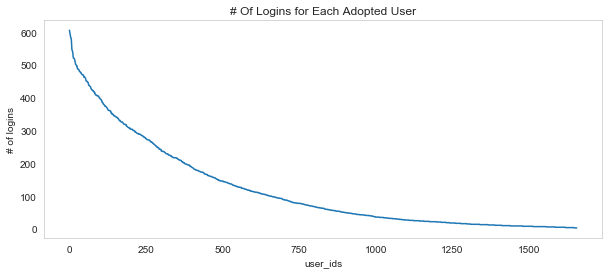

In [24]:
y = engagement_df[engagement_df.adopted_user == True].groupby('user_id')['date'].count().sort_values(ascending = False)
x = range(len(engagement_df[engagement_df.adopted_user == True \
                           ].groupby('user_id')['date'].count().sort_values(ascending = False)))
fig = plt.figure(figsize = (10,4))
plt.plot(x,y)
plt.xlabel('user_ids')
plt.ylabel('# of logins')
plt.title('# Of Logins for Each Adopted User')
plt.show()

In [25]:
#unadopted users login statistics
unadopted_min_login = engagement_df[engagement_df.adopted_user == False].groupby('user_id')['date'].count().min()
unadopted_max_login = engagement_df[engagement_df.adopted_user == False].groupby('user_id')['date'].count().max()
unadopted_avg_login = engagement_df[engagement_df.adopted_user == False].groupby('user_id')['date'].count().mean()

print(' Login average for adopted users is ',unadopted_avg_login, '\n',
      'Maximum number of logins for an adopted user is ',unadopted_max_login, '\n',
      'Minimum number of logins for an adopted user is ',unadopted_min_login)

 Login average for adopted users is  1.3380772987302916 
 Maximum number of logins for an adopted user is  15 
 Minimum number of logins for an adopted user is  1


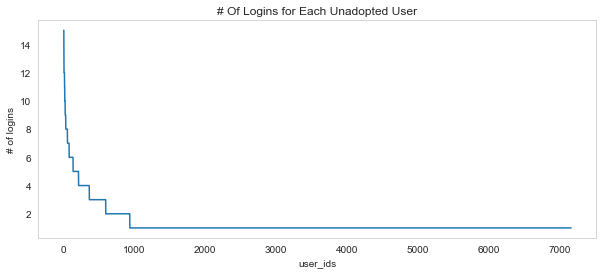

In [26]:
yu = engagement_df[engagement_df.adopted_user == False].groupby('user_id')['date'].count().sort_values(ascending = False)
xu = range(len(engagement_df[engagement_df.adopted_user == False \
                            ].groupby('user_id')['date'].count().sort_values(ascending = False)))
plt.figure(figsize = (10,4))
plt.plot(xu,yu)
plt.xlabel('user_ids')
plt.ylabel('# of logins')
plt.title('# Of Logins for Each Unadopted User')
plt.show()

We can observe that the adopted user's logins are more times than the unadopted.

__Percentage of adopted vs unadopted users with respect to opting into the mailing list__

In [27]:
users.groupby(['opted_in_to_mailing_list','adopted_users'])['object_id'].count() / len(users)

opted_in_to_mailing_list  adopted_users
0                         0                0.64825
                          1                0.10225
1                         0                0.21375
                          1                0.03575
Name: object_id, dtype: float64

__Percentage of adopted vs unadopted users with respect to their creation source__

In [28]:
users.groupby(['creation_source','adopted_users'])['object_id'].count() / len(users)

creation_source     adopted_users
GUEST_INVITE        0                0.149500
                    1                0.030750
ORG_INVITE          0                0.306667
                    1                0.047833
PERSONAL_PROJECTS   0                0.161583
                    1                0.014333
SIGNUP              0                0.148750
                    1                0.025167
SIGNUP_GOOGLE_AUTH  0                0.095500
                    1                0.019917
Name: object_id, dtype: float64

__Percentage of adopted vs unadopted users with respect to enabled market drip__

In [29]:
users.groupby(['enabled_for_marketing_drip','adopted_users'])['object_id'].count() / len(users)

enabled_for_marketing_drip  adopted_users
0                           0                0.734083
                            1                0.116583
1                           0                0.127917
                            1                0.021417
Name: object_id, dtype: float64

__Conclusion__

We can observe that the greatest indicator of adoption is how many times a user logs in. The unadopted users logged in on average 1.33 times while the adopted users had an average login of 119.76. However, due to the imbalance problem of the adopted user's data with that of unadopted, it is not feasible to draw meaningful statistics out of the categorical data provided.